# Segmentation

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from the readily available tfdataset by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

## Create Datasets

In [3]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "oxford_iiit_pet",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed"
    },
}

In [4]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict_raw = dd.read(dd_dict)

root dir set to None


In [5]:
ds_dict_raw

{'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'val': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

## alter dataset

In [6]:
def normalize_img(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # TODO: need to push augmentation to 
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    input_image, input_mask = normalize_img(input_image, input_mask)

    return input_image, input_mask

In [8]:
for k, cur_ds in ds_dict_raw.items():
    
    cur_ds = cur_ds.map(
            load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

    ds_dict_raw[k] = cur_ds

In [9]:
ds_dict = {"oxford_iiit_pet": ds_dict_raw}

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## Specify the Model

In [10]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

## Build the model

In [11]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_image (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 32) 896         x_image[0][0]                    
__________________________________________________________________________________________________
conv_2_downsample (Conv2D)      (None, 64, 64, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 64, 64, 64)   18496       conv_2_downsample[0][0]          
______________________________________________________________________________________________

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [13]:
ds_dict

{'oxford_iiit_pet': {'train': <ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>,
  'val': <ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>,
  'test': <ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>}}

In [14]:
%%time
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 1
train_logger: INFO     done validation - 2760
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 2
train_logger: INFO     done validation - 5520
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 3
train_logger: INFO     done validation - 8280
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 4
train_logger: INFO     done validation - 11040
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 5
train_logger: INFO  

train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 42
train_logger: INFO     done validation - 115920
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 43
train_logger: INFO     done validation - 118680
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 44
train_logger: INFO     done validation - 121440
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 45
train_logger: INFO     done validation - 124200
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - oxford_iiit_pet train: 46
train_logger: INFO     done validation - 126960
train_logger: INFO     optimizer: main_opt


CPU times: user 18min 30s, sys: 36.7 s, total: 19min 7s
Wall time: 8min 51s


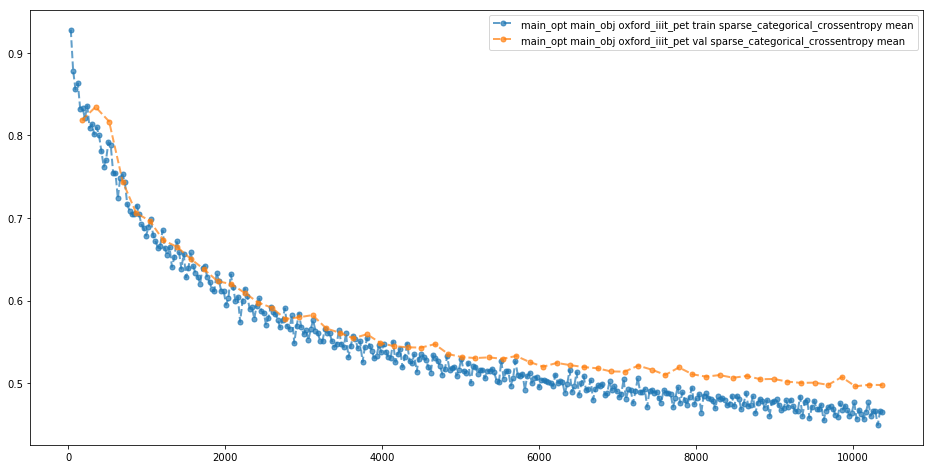

In [15]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=False,
    local=False,
    training=True,
    validation=True,
    loss=True,
    size=(16, 8),
)

## Evaluate the Model

## TODO: update logic below showing the output

In [16]:
from pathlib import Path
import matplotlib.pyplot as plt

from yeahml.train.setup.datasets import get_datasets

In [17]:
ds_proc = get_datasets(ds_dict, yml_dict["data"], yml_dict["hyper_parameters"])

In [18]:
for a in ds_proc['oxford_iiit_pet']['train'].take(1):
    z = model(a)

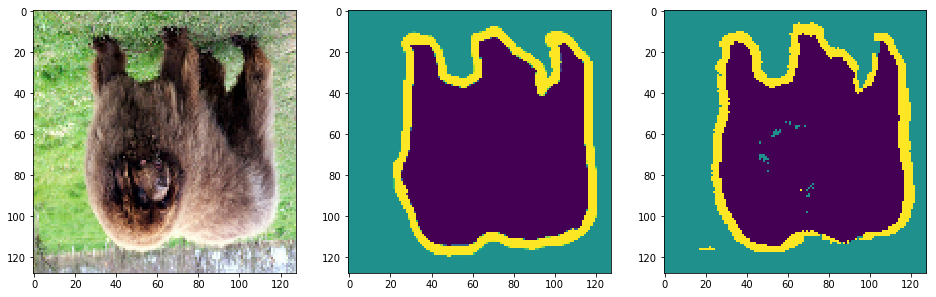

In [19]:
# hand picked "good"-ish example
plt_num = 6

fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes[0].imshow(tf.squeeze(a[0][plt_num]))
axes[1].imshow(tf.squeeze(a[1][plt_num]))
axes[2].imshow(tf.argmax(z[plt_num], axis=-1))

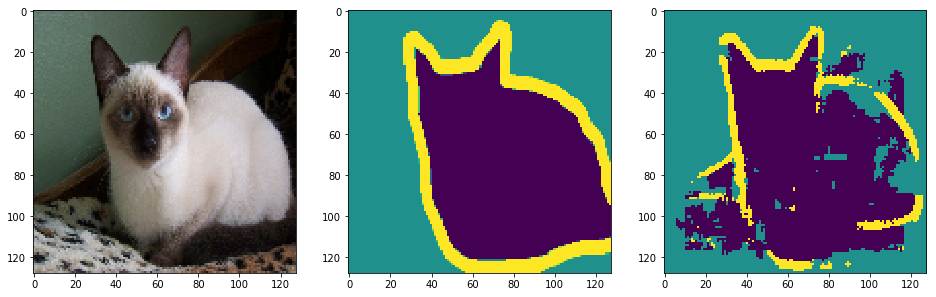

In [23]:
# hand picked less "good"-ish example
plt_num = 3

fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes[0].imshow(tf.squeeze(a[0][plt_num]))
axes[1].imshow(tf.squeeze(a[1][plt_num]))
axes[2].imshow(tf.argmax(z[plt_num], axis=-1))

In [15]:
# eval_dict = yml.eval_model(
#     model,
#     yml_dict,
#     dataset=ds_dict["test"]
# )
# print(eval_dict)

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```